LSTM + ATTENTION V2 - OPTIMIZADO
Device: cpu
Train: 1460 days | Test: 365 days
Lookback: 60
Architecture: 1-layer LSTM, hidden 64
Dropout: 0.5, Weight Decay: 0.001

📂 Loading M5 data...
Product: FOODS_3_090_CA_3_validation
Series length: 1913 days

🧱 Building features...
Features: 11

Train: 1460 days
Test:  365 days

📏 Scaling with MinMaxScaler...
X_train: (1460, 11), y in [0,1]
Train windows: (1400, 60, 11)
Test windows:  (305, 60, 11)

🤖 Building simplified LSTM...
Parameters: 19,842

🎯 Training...
Epoch   1 | Train: 0.037053 | Val: 0.020282 | LR: 9.76e-04
Epoch  10 | Train: 0.019095 | Val: 0.012821 | LR: 1.00e-03
Epoch  20 | Train: 0.016415 | Val: 0.013885 | LR: 5.01e-04
Epoch  30 | Train: 0.015401 | Val: 0.017198 | LR: 1.00e-03
Early stopping at epoch 38

🔮 Generating predictions...

📊 RESULTS
TEST SET:
  : MAE=72.62, RMSE=86.36, MAPE=442.77%, Bias=-1.78


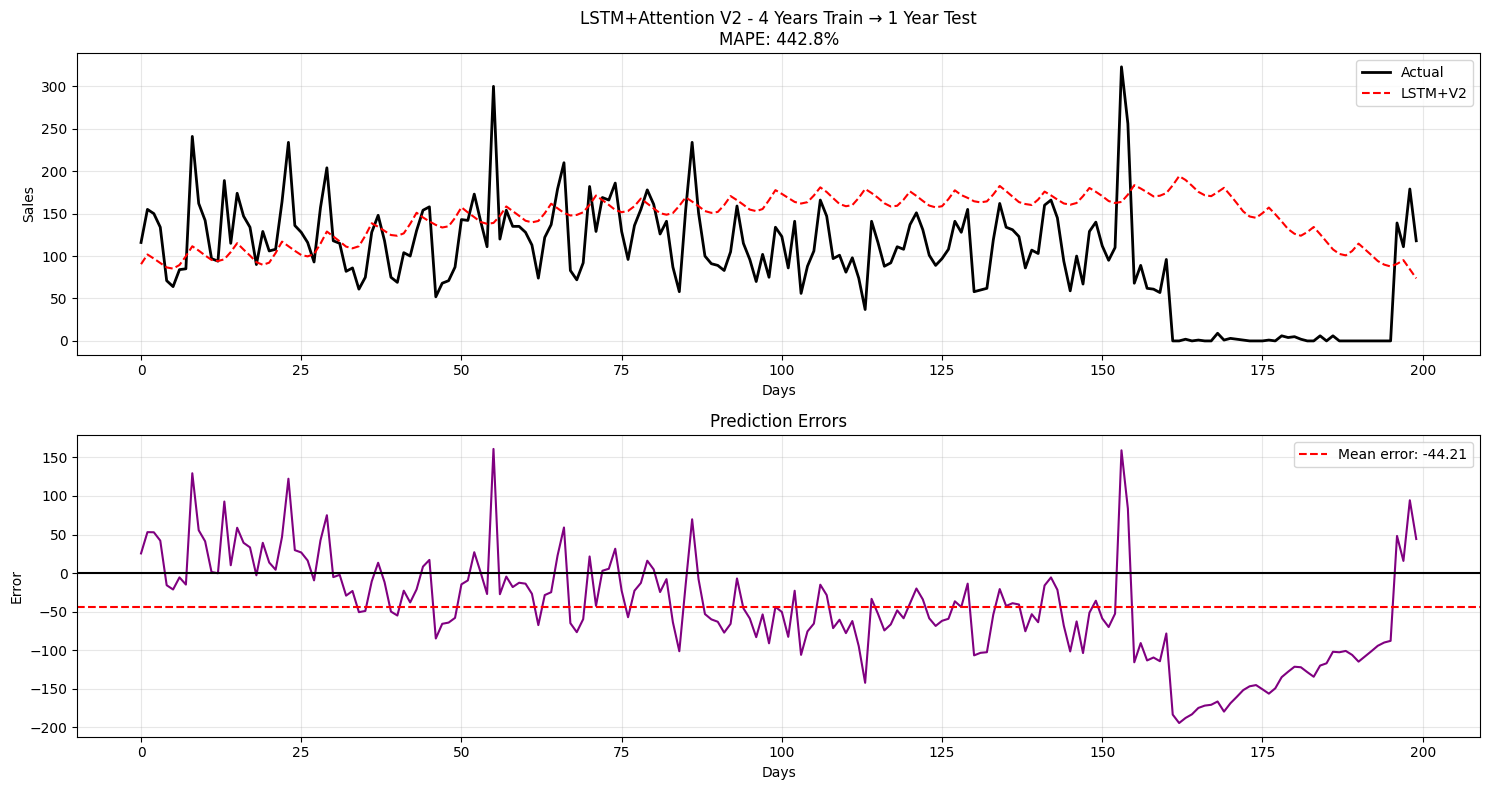


✅ LSTM V2 COMPLETED

TEST METRICS:
   MAE:  72.62
   RMSE: 86.36
   MAPE: 442.77%
   Bias: -1.78



In [ ]:
# ============================================================
# LSTM + ATTENTION V2 - FIXED AND OPTIMIZED
# ============================================================
# Key changes:
# 1. MinMaxScaler instead of StandardScaler
# 2. 50% dropout and 1e-3 weight decay
# 3. Smaller model capacity (64 hidden units, 1 layer)
# 4. Cosine annealing learning rate scheduler
# 5. More aggressive gradient clipping
# ============================================================

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler  # Critical change for stable scaling in this setup
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# OPTIMIZED CONFIGURATION
# ============================================================
SEED = 42
LOOKBACK = 60        # Reduced from 90 to 60
HORIZON = 1
TRAIN_DAYS = 1460
TEST_DAYS = 365

BATCH_SIZE = 32      # Smaller batch size can improve generalization
EPOCHS = 60
LR = 1e-3
PATIENCE = 20

# Reduced architecture (less overfitting risk)
HIDDEN_DIM = 64      # Reduced from 128
NUM_LAYERS = 1       # Reduced from 2
DROPOUT = 0.5        # Increased from 0.3
ATTENTION_DIM = 32   # Reduced from 64
WEIGHT_DECAY = 1e-3  # Increased from 1e-4

# Set all random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("="*70)
print("LSTM + ATTENTION V2 - OPTIMIZED")
print("="*70)
print(f"Device: {device}")
print(f"Train: {TRAIN_DAYS} days | Test: {TEST_DAYS} days")
print(f"Lookback: {LOOKBACK}")
print(f"Architecture: {NUM_LAYERS}-layer LSTM, hidden {HIDDEN_DIM}")
print(f"Dropout: {DROPOUT}, Weight Decay: {WEIGHT_DECAY}")
print("="*70)

# ============================================================
# LOAD DATA
# ============================================================
print("\n📂 Loading M5 data...")
sales = pd.read_csv("../data/raw/sales_train_validation.csv")
calendar = pd.read_csv("../data/raw/calendar.csv")
prices = pd.read_csv("../data/raw/sell_prices.csv")

calendar['date'] = pd.to_datetime(calendar['date'])
d_cols = [c for c in sales.columns if c.startswith('d_')]

# Select one product series
product_id = "FOODS_3_090_CA_3_validation"
row = sales[sales['id'] == product_id].iloc[0]
item_id = row['item_id']
store_id = row['store_id']
state_id = store_id.split('_')[0]

print(f"Product: {product_id}")

# ============================================================
# BUILD TIME SERIES
# ============================================================
df = pd.DataFrame({'d': d_cols, 'sales': row[d_cols].values.astype(np.float32)})
df = df.merge(calendar[['d', 'date', 'wm_yr_wk', 'snap_CA', 'snap_TX', 'snap_WI']], on='d', how='left')

# Merge product/store price history
price_sub = prices[(prices['item_id'] == item_id) & (prices['store_id'] == store_id)]
if len(price_sub) > 0:
    price_sub = price_sub[['wm_yr_wk', 'sell_price']].drop_duplicates()
    df = df.merge(price_sub, on='wm_yr_wk', how='left')
    # Fill gaps in prices to avoid missing values during training
    df['sell_price'] = df['sell_price'].ffill().bfill().fillna(0)
else:
    df['sell_price'] = 0

print(f"Series length: {len(df)} days")

# ============================================================
# FEATURE ENGINEERING (SIMPLIFIED)
# ============================================================
print("\n🧱 Building features...")

snap_col = f"snap_{state_id}" if f"snap_{state_id}" in df.columns else 'snap_CA'

# Basic calendar features
df['dow'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['is_weekend'] = (df['dow'] >= 5).astype(int)

# Most informative lags only
for lag in [1, 7, 14, 28]:
    df[f'lag_{lag}'] = df['sales'].shift(lag)

# Essential rolling statistics only
df['roll_mean_7'] = df['sales'].rolling(7, min_periods=1).mean()
df['roll_mean_28'] = df['sales'].rolling(28, min_periods=1).mean()

# Ensure no NaNs remain before scaling/modeling
df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)

feature_cols = [
    snap_col, 'sell_price', 'dow', 'month', 'is_weekend',
    'lag_1', 'lag_7', 'lag_14', 'lag_28',
    'roll_mean_7', 'roll_mean_28'
]
feature_cols = [c for c in feature_cols if c in df.columns]

print(f"Features: {len(feature_cols)}")

# ============================================================
# 4 YEARS TRAIN / 1 YEAR TEST SPLIT
# ============================================================
start_idx = len(df) - (TRAIN_DAYS + TEST_DAYS)
df_final = df.iloc[start_idx:].reset_index(drop=True)

train_df = df_final.iloc[:TRAIN_DAYS]
test_df = df_final.iloc[TRAIN_DAYS:]

print(f"\nTrain: {len(train_df)} days")
print(f"Test:  {len(test_df)} days")

# ============================================================
# SCALING WITH MINMAX (CRITICAL)
# ============================================================
print("\n📏 Scaling with MinMaxScaler...")

X_train_raw = train_df[feature_cols].values.astype(np.float32)
y_train_raw = train_df['sales'].values.astype(np.float32).reshape(-1, 1)
X_test_raw = test_df[feature_cols].values.astype(np.float32)
y_test_raw = test_df['sales'].values.astype(np.float32).reshape(-1, 1)

scaler_X = MinMaxScaler(feature_range=(-1, 1))  # Symmetric range for input features
scaler_y = MinMaxScaler(feature_range=(0, 1))   # Sales are non-negative by definition

# Fit scalers only on training data to prevent data leakage
scaler_X.fit(X_train_raw)
scaler_y.fit(y_train_raw)

X_train = scaler_X.transform(X_train_raw)
X_test = scaler_X.transform(X_test_raw)
y_train = scaler_y.transform(y_train_raw).flatten()
y_test = scaler_y.transform(y_test_raw).flatten()

print(f"X_train: {X_train.shape}, y in [0,1]")

# ============================================================
# WINDOW GENERATION
# ============================================================
def create_windows(X, y, lookback):
    X_w, y_w = [], []
    for i in range(len(X) - lookback):
        # Input: previous `lookback` timesteps
        X_w.append(X[i:i+lookback])
        # Target: next timestep value (one-step ahead forecast)
        y_w.append(y[i+lookback])
    return np.array(X_w, dtype=np.float32), np.array(y_w, dtype=np.float32)

X_train_w, y_train_w = create_windows(X_train, y_train, LOOKBACK)
X_test_w, y_test_w = create_windows(X_test, y_test, LOOKBACK)

print(f"Train windows: {X_train_w.shape}")
print(f"Test windows:  {X_test_w.shape}")

# Use the last 20% of training windows as validation set (time-aware split)
val_size = int(0.2 * len(X_train_w))
X_val_w = X_train_w[-val_size:]
y_val_w = y_train_w[-val_size:]
X_train_w = X_train_w[:-val_size]
y_train_w = y_train_w[:-val_size]

# ============================================================
# DATALOADERS
# ============================================================
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train_w), torch.from_numpy(y_train_w)),
    batch_size=BATCH_SIZE, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_val_w), torch.from_numpy(y_val_w)),
    batch_size=BATCH_SIZE, shuffle=False
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test_w), torch.from_numpy(y_test_w)),
    batch_size=BATCH_SIZE, shuffle=False
)

# ============================================================
# SIMPLIFIED MODEL
# ============================================================
print("\n🤖 Building simplified LSTM...")

class SimpleAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # Produces one attention score per timestep
        self.attention = nn.Linear(hidden_dim, 1)
    
    def forward(self, lstm_out):
        # Softmax over time dimension => normalized timestep importance weights
        weights = torch.softmax(self.attention(lstm_out), dim=1)
        # Weighted sum of sequence outputs => context vector
        return torch.sum(weights * lstm_out, dim=1)

class LSTMAttentionV2(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers, dropout=0.5):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=in_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            # PyTorch applies LSTM dropout only when num_layers > 1
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.attention = SimpleAttention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context = self.attention(lstm_out)
        context = self.dropout(context)
        return self.fc(context)

model = LSTMAttentionV2(
    in_dim=len(feature_cols),
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss()

# Cosine annealing with warm restarts for smoother LR cycles
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

# ============================================================
# TRAINING WITH EARLY STOPPING
# ============================================================
print("\n🎯 Training...")
print("="*70)

best_val = float('inf')
best_state = None
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    # Train phase
    model.train()
    train_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device).unsqueeze(-1)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        
        # Aggressive gradient clipping to stabilize updates
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        
        optimizer.step()
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device).unsqueeze(-1)
            val_loss += criterion(model(Xb), yb).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    # Update LR each epoch according to scheduler policy
    scheduler.step()
    
    if val_loss < best_val:
        best_val = val_loss
        # Save best model weights (deep copy to CPU)
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 10 == 0 or epoch == 1:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch:3d} | Train: {train_loss:.6f} | Val: {val_loss:.6f} | LR: {current_lr:.2e}")
    
    if patience_counter >= PATIENCE:
        print(f"Early stopping at epoch {epoch}")
        break

# ============================================================
# PREDICTIONS
# ============================================================
print("\n🔮 Generating predictions...")

# Restore best validation model before inference
model.load_state_dict(best_state)
model.eval()

@torch.no_grad()
def predict(loader):
    preds = []
    for Xb, _ in loader:
        preds.append(model(Xb.to(device)).cpu().numpy())
    return np.concatenate(preds)

train_pred_s = predict(train_loader)
test_pred_s = predict(test_loader)

# Convert predictions back to original sales scale
train_pred = scaler_y.inverse_transform(train_pred_s.reshape(-1, 1)).flatten()
train_true = scaler_y.inverse_transform(y_train_w.reshape(-1, 1)).flatten()
test_pred = scaler_y.inverse_transform(test_pred_s.reshape(-1, 1)).flatten()
test_true = scaler_y.inverse_transform(y_test_w.reshape(-1, 1)).flatten()

# Enforce non-negative demand predictions
train_pred = np.maximum(train_pred, 0)
test_pred = np.maximum(test_pred, 0)

# ============================================================
# METRICS
# ============================================================
print("\n📊 RESULTS")
print("="*70)

def metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # Compute MAPE only where true demand > 0 to avoid division by zero
    mask = y_true > 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.sum() > 0 else np.nan
    bias = np.mean(y_pred - y_true)
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%, Bias={bias:.2f}")
    return mae, rmse, mape, bias

print("TEST SET:")
test_mae, test_rmse, test_mape, test_bias = metrics(test_true, test_pred, "  ")

# ============================================================
# VISUALIZATION
# ============================================================
plt.figure(figsize=(15, 8))

# Plot 1: Actual vs predicted values
plt.subplot(2, 1, 1)
plot_steps = min(200, len(test_true))
plt.plot(test_true[:plot_steps], color='black', linewidth=2, label='Actual')
plt.plot(test_pred[:plot_steps], color='red', linewidth=1.5, linestyle='--', label='LSTM+V2')
plt.title(f'LSTM+Attention V2 - 4 Years Train → 1 Year Test\nMAPE: {test_mape:.1f}%', fontsize=12)
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Residual errors
plt.subplot(2, 1, 2)
errors = test_true[:plot_steps] - test_pred[:plot_steps]
plt.plot(errors, color='purple', linewidth=1.5)
plt.axhline(0, color='black', linestyle='-')
plt.axhline(np.mean(errors), color='red', linestyle='--', label=f'Mean error: {np.mean(errors):.2f}')
plt.title('Prediction Errors')
plt.xlabel('Days')
plt.ylabel('Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_v2_results.png', dpi=150)
plt.show()

print("\n" + "="*70)
print("✅ LSTM V2 COMPLETED")
print("="*70)
print(f"""
TEST METRICS:
   MAE:  {test_mae:.2f}
   RMSE: {test_rmse:.2f}
   MAPE: {test_mape:.2f}%
   Bias: {test_bias:.2f}
""")
